In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, MessagesState,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from typing_extensions import Annotated, Literal,TypedDict, List
from langchain_core.tools import tool

from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0.3)
    response = llm.invoke("Are you ready to help me")
    print(response.content)
except Exception as e:
    print(f"Error initializing LLM: {e}")
    

Yes, absolutely! I'm ready to help.

What can I assist you with today? Please tell me what you need.


## Document Load

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

In [4]:
file_path = './data/cover_letter.pdf'
loader = PyPDFLoader(file_path,mode='single')
docs=loader.load()
spliter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0,separator="\n")
texts = spliter.split_documents(docs)

In [5]:
# texts

In [6]:
# docs=loader.load()

In [7]:
# docs

In [8]:
# spliter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0,separator="\n\n")
# texts = spliter.split_documents(docs)

In [9]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0,is_separator_regex=True, separators=["\n\n", "\n", " ", ""])

In [10]:
# text_splitter.split_documents(docs)

## create vectorstore

In [11]:
# embedding 
embeddings = GoogleGenerativeAIEmbeddings(model='models/gemini-embedding-001')
vectorstore = Chroma.from_documents(texts,embedding=embeddings,collection_name="sample_collection",persist_directory="./data/chroma_db")

## Create retrival tool

In [12]:
from langchain.tools.retriever import create_retriever_tool
retriver_tool = create_retriever_tool(
    retriever=vectorstore.as_retriever(),
    name="retriever_tool",
    description="""This tool is used to retrieve relevant documents from the vector store based on the user's query.
                   the informmation is about a person named 'Natdanai intraraksa' who is a software engineer and has worked at various companies including Invitrace and others.
    """)

In [13]:
a = vectorstore.similarity_search("Which framework that I use to build the agent?")

In [14]:
a

[Document(id='56604853-a576-4683-a8c6-1565bbaf76a4', metadata={'total_pages': 2, 'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': 'PyPDF', 'creationdate': '', 'source': './data/cover_letter.pdf', 'title': 'Cover letter for apexanalytix'}, page_content='frameworks\n \nlike\n \nLangGraph\n \nand\n \nCrewAI\n \nto\n \nmanage\n \nautonomous\n \ntask\n \ndelegation\n \nand\n \nexecution\n \n \n I  have  hands-on  experience  fine-tuning  LLMs  with  techniques  such  as  \nLoRA,\n \nQLoRA,\n \nand\n \ninstruction\n \ntuning,\n \nand\n \nhave\n \nworked\n \nextensively\n \nwith\n \nLangChain,'),
 Document(id='4ebaa4b5-d978-461d-9e85-da86118fd5fe', metadata={'creator': 'PyPDF', 'source': './data/cover_letter.pdf', 'total_pages': 2, 'producer': 'Skia/PDF m140 Google Docs Renderer', 'title': 'Cover letter for apexanalytix', 'creationdate': ''}, page_content='frameworks\n \nlike\n \nLangGraph\n \nand\n \nCrewAI\n \nto\n \nmanage\n \nautonomous\n \ntask\n \ndelegation\n \nand\n \nexec

In [15]:
@tool
def retrieve_documents(query: str):
    """Tools for retrive information that relevant to my information of the users"""
    results = vectorstore.similarity_search(query)
    return results

@tool
def multiply_numbers(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b + 9

tools = [retrieve_documents, multiply_numbers]

def query_vectorstore(state:MessagesState):
    prompt = ''' you are AI agent that answer the question by using tools'''
    agent = create_react_agent(llm, tools=[retriver_tool], prompt=prompt)
    result = agent.invoke({'messages':state['messages']})
    return {'messages': result['messages']}

def Agent(state:MessagesState):
    llm_with_tools = llm.bind_tools([retriver_tool])
    response = llm_with_tools.invoke(state['messages'])
    return response

    

In [16]:
state = MessagesState()
state['messages'] = "What does Natdanai do at Samutprakarn hospitals?"

r = Agent(state)
r2 = query_vectorstore(state)

In [17]:
r

AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "What does Natdanai do at Samutprakarn hospitals?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--67eefe0f-46c0-4765-acd9-a4e4168c5ed7-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'What does Natdanai do at Samutprakarn hospitals?'}, 'id': '81124946-eead-4a2d-8db2-cb7e6f6d2825', 'type': 'tool_call'}], usage_metadata={'input_tokens': 110, 'output_tokens': 95, 'total_tokens': 205, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}})

In [18]:
r2['messages']

[HumanMessage(content='What does Natdanai do at Samutprakarn hospitals?', additional_kwargs={}, response_metadata={}, id='d8627d43-3b0e-4bd1-878d-ec2d7eda491f'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "What does Natdanai do at Samutprakarn hospitals?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--862086ab-99b0-4de7-ab53-9f5ff34db955-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'What does Natdanai do at Samutprakarn hospitals?'}, 'id': 'f1e589b5-9851-4ecc-a21a-f79c69512884', 'type': 'tool_call'}], usage_metadata={'input_tokens': 121, 'output_tokens': 189, 'total_tokens': 310, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 160}}),
 ToolMessage(content='retrieval-augmented\n \ngeneration\n \n(RAG)\n \nto\n \nprovide\n \nreal-time,\n \ncontext

## Grade Document


In [19]:
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

In [20]:
def grade_documents(state:MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert at determining the relevance of documents to a given question."),
        ("user", """Given the question and the retrieved documents, determine if the documents are relevant to answer the question.
                    Respond with 'yes' if relevant, or 'no' if not relevant.
                    Question: {question}
                    Documents: {documents}""")
    ])
    # Extract the question and documents from the state
    question = state['messages'] if isinstance(state['messages'], str) else state['messages'][0].content
    documents = state['messages'][-1].content if hasattr(state['messages'][-1], 'content') else str(state['messages'])

    # Format the prompt first
    formatted_prompt = prompt.format_messages(
        question=question,
        documents=documents
    )
    
    llm_with_structured_output = llm.with_structured_output(GradeDocuments)
    response = llm_with_structured_output.invoke(formatted_prompt)
    if response.binary_score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"
    
   

grade_documents(r2)

'generate_answer'

## Rewrite node


In [21]:

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""


    REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
    )
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [22]:
def generate_answer(state: MessagesState):
    """Generate an answer."""

    GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
    )

    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

## Construct Graph

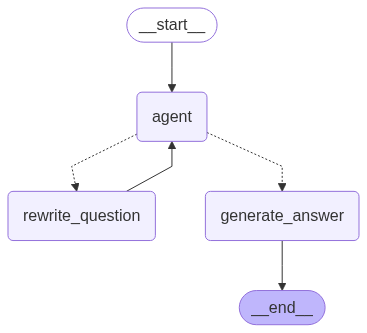

In [ ]:
# Create the workflow

workflow = StateGraph(MessagesState)
workflow.add_node("agent",query_vectorstore)
# workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("generate_answer", generate_answer)
workflow.add_edge(START,"agent")
# workflow.add_edge("agent", "grade_documents")
workflow.add_conditional_edges('agent',
        grade_documents, {
        "generate_answer": "generate_answer",
        "rewrite_question": "rewrite_question",})
workflow.add_edge("rewrite_question", "agent")
workflow.add_edge("generate_answer", END)
workflow.compile()